In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import bemcs

# Two-element model geometry
- Three points, $\mathrm{a}$, $\mathrm{b}$, and $\mathrm{c}$
- Two elements $\mathrm{ab}$ and $\mathrm{bc}$

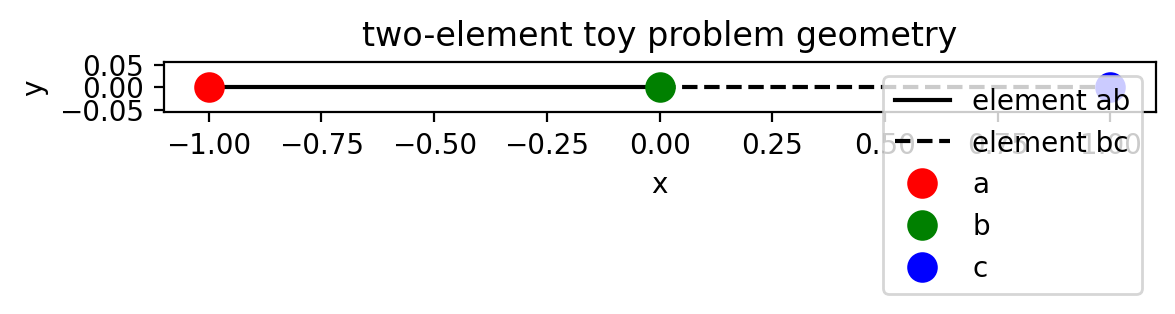

In [2]:
markersize = 20
plt.figure()
plt.plot([-1, 0], [0, 0], "-k", label="element ab")
plt.plot([0, 1], [0, 0], "--k", label="element bc")
plt.plot(-1, 0, "r.", label="a", markersize=markersize)
plt.plot(0, 0, "g.", label="b", markersize=markersize)
plt.plot(1, 0, "b.", label="c", markersize=markersize)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.gca().set_aspect("equal")
plt.title("two-element toy problem geometry")
plt.show()


# Constructing continous quadratic slip across two elements
The goal is for both slip, and it's derivative, to be continuous everhwere including, critcally, at points $\mathrm{b}$ the junction between elements $\mathrm{ab}$ and $\mathrm{bc}$ 

## Basic slip functions over each element
For the element $\mathrm{ab}$ the element slip is defined by,

$
\begin{equation}
    y_\mathrm{ab}(x) = \sum_{i=1}^3 \phi_{\mathrm{ab}, i} f_{\mathrm{ab}, i}(x)
\end{equation}
$

where $\phi_{\mathrm{ab}, i}$ are the quadratic weights and  $f_{\mathrm{ab}, i}(x)$ are the quadratic slip functions given by.  The slip gradients are similarly given by,

$
\begin{equation}
    \frac{dy_\mathrm{ab}(x)}{dx} = \sum_{i=1}^3 \phi_{\mathrm{ab}, i} \frac{df_{\mathrm{ab}, i}(x)}{dx}
\end{equation}
$

The slip functions are individually quadratic and assume a local coordinate system, $x'$,  such that the effective center of each element is at zero.  For the element $\mathrm{ab}$ the individual functions are,

$f_{\mathrm{ab}, 1}(x') = \frac{x'}{a} (\frac{9x'}{8a} - \frac{3}{4})$

$f_{\mathrm{ab}, 2}(x') = (1 - \frac{3x'}{2a})  (1 + \frac{3x'}{2a})$

$f_{\mathrm{ab}, 3}(x') = \frac{x'}{a} (\frac{9x'}{8a} + \frac{3}{4})$

where $a$ is the half width of an individual element $\mathrm{ab}$.  We'll also need the derivatives and those are given by,

$\frac{df_{\mathrm{ab}, 1}(x')}{dx'} = \frac{9x'}{4a^2} - \frac{3}{4a}$

$\frac{df_{\mathrm{ab}, 2}(x')}{dx'} = \frac{9x'}{2a^2}$

$\frac{df_{\mathrm{ab}, 3}(x')}{dx'} = \frac{9x'}{4a^2} + \frac{3}{4a}$

Similarly, the functions are identical for element $\mathrm{bc}$.

## Boundary conditions
We have six boundary conditions:

1. $y_\mathrm{ab}(x_\mathrm{a}) = u_\mathrm{a}$, slip at point $\mathrm{a}$

2. $y_\mathrm{bc}(x_\mathrm{c}) = u_\mathrm{c}$, slip at point $\mathrm{c}$

3. $\frac{dy_\mathrm{ab}(x_\mathrm{a})}{dx} = \frac{du_\mathrm{a}}{dx}$, slip gradient at point $\mathrm{a}$

4. $\frac{dy_\mathrm{bc}(x_\mathrm{c})}{dx} = \frac{du_\mathrm{c}}{dx}$, slip gradient at point $\mathrm{c}$

5. $y_\mathrm{ab}(x_\mathrm{b}) + y_\mathrm{bc}(x_\mathrm{b}) = 2 u_\mathrm{b}$, slip contintuity at point, $b$.  Not sure if this is the best way to do this.  An alternative is, $y_\mathrm{ab}(x_\mathrm{b}) - y_\mathrm{bc}(x_\mathrm{b}) = 0$ but I don't know how to set the slip at $b$ then.

6. $\frac{dy_\mathrm{ab}(x_\mathrm{b})}{dx} = \frac{dy_\mathrm{bc}(x_\mathrm{b})}{dx}$ continuity of slip gradient at point, $\mathrm{b}$.

## Building the linear system
We now have six equations and six unknowns, ($\phi_{\mathrm{ab}, 1}$, $\phi_{\mathrm{ab}, 2}$, $\phi_{\mathrm{ab}, 3}$, $\phi_{\mathrm{bc}, 1}$, $\phi_{\mathrm{bc}, 2}$, and $\phi_{\mathrm{bc}, 3}$).  The next step is to write this as linear system so that we can solve for the quadratic coefficients,
$
\begin{equation}
    \begin{bmatrix}
        u_\mathrm{a}\\
        u_\mathrm{c}\\
        \frac{d u_\mathrm{a}}{dx}\\
        \frac{d u_\mathrm{c}}{dx}\\
        2u_b\\
        0
    \end{bmatrix}
    =
    \begin{bmatrix}
        f_{\mathrm{ab}, 1}(x_\mathrm{a}) & f_{\mathrm{ab}, 2}(x_\mathrm{a}) & f_{\mathrm{ab}, 3}(x_\mathrm{a}) & 0 & 0 & 0\\
        0 & 0 & 0 & f_{\mathrm{bc}, 1}(x_\mathrm{c}) & f_{\mathrm{bc}, 2}(x_\mathrm{c}) & f_{\mathrm{bc}, 3}(x_\mathrm{c})\\
        \frac{df_{\mathrm{ab}, 1}(x_\mathrm{a})}{dx} & \frac{df_{\mathrm{ab}, 2}(x_\mathrm{a})}{dx} & \frac{df_{\mathrm{ab}, 3}(x_\mathrm{a})}{dx} & 0 & 0 & 0\\
        0 & 0 & 0 & \frac{df_{\mathrm{bc}, 1}(x_\mathrm{c})}{dx} & \frac{df_{\mathrm{bc}, 2}(x_\mathrm{c})}{dx} & \frac{df_{\mathrm{bc}, 3}(x_\mathrm{c})}{dx}\\
        f_{\mathrm{ab}, 1}(x_\mathrm{b}) & f_{\mathrm{ab}, 2}(x_\mathrm{b}) & f_{\mathrm{ab}, 3}(x_\mathrm{b}) & f_{\mathrm{bc}, 1}(x_\mathrm{b}) & f_{\mathrm{bc}, 2}(x_\mathrm{b}) & f_{\mathrm{bc}, 3}(x_\mathrm{b})\\
        \frac{df_{\mathrm{ab}, 1}(x_\mathrm{a})}{dx} & \frac{df_{\mathrm{ab}, 2}(x_\mathrm{a})}{dx} & \frac{df_{\mathrm{ab}, 3}(x_\mathrm{a})}{dx} & -\frac{df_{\mathrm{bc}, 1}(x_\mathrm{c})}{dx} & -\frac{df_{\mathrm{bc}, 2}(x_\mathrm{c})}{dx} & -\frac{df_{\mathrm{bc}, 3}(x_\mathrm{c})}{dx}
    \end{bmatrix}
    \begin{bmatrix}
        \phi_{\mathrm{ab}, 1}\\
        \phi_{\mathrm{ab}, 2}\\
        \phi_{\mathrm{ab}, 3}\\
        \phi_{\mathrm{bc}, 1}\\
        \phi_{\mathrm{bc}, 2}\\
        \phi_{\mathrm{bc}, 3}
   \end{bmatrix}
\end{equation}
$

With this linear system we can solve for all $\phi$ quadratic weights for the simple two element model (assuming that we're not rank degenerate).

## Important note
More needs to be done for the systems with more than two elements.  The reason for this is that each additional "internal" element that we add will only add two equations to the linear system (one for slip continuity and one for slip gradient continuity).  We need an additional constraint because each new element adds three quadratic weights that we need so solve for.  Possibilities for an additional constraint are:
- Mean slip over the element
- Slip at center of the element



# Define the functions we need to populate the linear operator
- Looks like a ton of redundancy (that can later be simplified) but I'm keeping this for now so that notation is consistent with the latex above

In [3]:
# Slip functions
def f_ab_1(x, a):
    return (x / a) * (9 * (x / a) / 8 - 3 / 4)


def f_ab_2(x, a):
    return (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)


def f_ab_3(x, a):
    return (x / a) * (9 * (x / a) / 8 + 3 / 4)


def f_bc_1(x, a):
    return (x / a) * (9 * (x / a) / 8 - 3 / 4)


def f_bc_2(x, a):
    return (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)


def f_bc_3(x, a):
    return (x / a) * (9 * (x / a) / 8 + 3 / 4)


# Slip gradient functions
def d_f_ab_1_dx(x, a):
    return (9 * x) / (4 * a**2) - 3 / (4 * a)


def d_f_ab_2_dx(x, a):
    return (9 * x) / (2 * a**2)


def d_f_ab_3_dx(x, a):
    return (9 * x) / (4 * a**2) + 3 / (4 * a)


def d_f_bc_1_dx(x, a):
    return (9 * x) / (4 * a**2) - 3 / (4 * a)


def d_f_bc_2_dx(x, a):
    return (9 * x) / (2 * a**2)


def d_f_bc_3_dx(x, a):
    return (9 * x) / (4 * a**2) + 3 / (4 * a)


# Build the linear system

In [8]:
data_vector = np.zeros(6)
data_vector[0] = 1.0  # slip at a
data_vector[1] = 1.0  # slip at c
data_vector[2] = 0.0  # slip gradient at a
data_vector[3] = 0.0  # slip gradient at c
data_vector[4] = 2.0  # sum of slip from ab and bc at b
data_vector[5] = 0.0  # slip gradient at b

linear_operator = np.zeros((6, 6))
x_a = -1.0
x_b = 0.0
x_c = 1.0
x_ab_centroid = 0.5 * (x_a + x_b)
x_bc_centroid = 0.5 * (x_b + x_c)
a = 0.5

# First row
linear_operator[0, 0] = f_ab_1(x_a - x_ab_centroid, a)
linear_operator[0, 1] = f_ab_2(x_a - x_ab_centroid, a)
linear_operator[0, 2] = f_ab_3(x_a - x_ab_centroid, a)
linear_operator[0, 3] = 0
linear_operator[0, 4] = 0
linear_operator[0, 5] = 0

# Second row
linear_operator[1, 0] = 0
linear_operator[1, 1] = 0
linear_operator[1, 2] = 0
linear_operator[1, 3] = f_bc_1(x_c - x_bc_centroid, a)
linear_operator[1, 4] = f_bc_2(x_c - x_bc_centroid, a)
linear_operator[1, 5] = f_bc_3(x_c - x_bc_centroid, a)

# Third row
linear_operator[2, 0] = d_f_ab_1_dx(x_a - x_ab_centroid, a)
linear_operator[2, 1] = d_f_ab_2_dx(x_a - x_ab_centroid, a)
linear_operator[2, 2] = d_f_ab_3_dx(x_a - x_ab_centroid, a)
linear_operator[2, 3] = 0
linear_operator[2, 4] = 0
linear_operator[2, 5] = 0

# Fouth row
linear_operator[3, 0] = 0
linear_operator[3, 1] = 0
linear_operator[3, 2] = 0
linear_operator[3, 3] = d_f_bc_1_dx(x_c - x_bc_centroid, a)
linear_operator[3, 4] = d_f_bc_2_dx(x_c - x_bc_centroid, a)
linear_operator[3, 5] = d_f_bc_3_dx(x_c - x_bc_centroid, a)

# Fifth row
linear_operator[4, 0] = f_ab_1(x_b - x_ab_centroid, a)
linear_operator[4, 1] = f_ab_2(x_b - x_ab_centroid, a)
linear_operator[4, 2] = f_ab_3(x_b - x_ab_centroid, a)
linear_operator[4, 3] = f_bc_1(x_b - x_bc_centroid, a)
linear_operator[4, 4] = f_bc_2(x_b - x_bc_centroid, a)
linear_operator[4, 5] = f_bc_3(x_b - x_bc_centroid, a)

# Sixth row
linear_operator[5, 0] = d_f_ab_1_dx(x_b - x_ab_centroid, a)
linear_operator[5, 1] = d_f_ab_2_dx(x_b - x_ab_centroid, a)
linear_operator[5, 2] = d_f_ab_3_dx(x_b - x_ab_centroid, a)
linear_operator[5, 3] = -d_f_bc_1_dx(x_b - x_bc_centroid, a)
linear_operator[5, 4] = -d_f_bc_2_dx(x_b - x_bc_centroid, a)
linear_operator[5, 5] = -d_f_bc_3_dx(x_b - x_bc_centroid, a)

print(linear_operator)
print(f"{np.linalg.cond(linear_operator)=}")

print(" ")
linear_operator_rank = np.linalg.matrix_rank(linear_operator)
print(f"{linear_operator_rank=}")
if linear_operator_rank == 6:
    print("linear_operator is full rank")
elif linear_operator_rank < 6:
    print("LINEAR_OPERATOR IS NOT FULL RANK")
print(" ")

# Solve linear system for quadratic weights
quadratic_weights = np.linalg.inv(linear_operator) @ data_vector
print(f"{quadratic_weights=}")


[[ 1.875 -1.25   0.375  0.     0.     0.   ]
 [ 0.     0.     0.     0.375 -1.25   1.875]
 [-6.    -9.    -3.     0.     0.     0.   ]
 [ 0.     0.     0.     3.     9.     6.   ]
 [ 0.375 -1.25   1.875  1.875 -1.25   0.375]
 [ 3.     9.     6.     6.     9.     3.   ]]
np.linalg.cond(linear_operator)=1.3371910581728067e+17
 
linear_operator_rank=5
LINEAR_OPERATOR IS NOT FULL RANK
 
quadratic_weights=array([ 0.375 , -0.25  ,  0.    ,  0.5   , -0.3125,  0.125 ])


# Plot slip across elements ab and bc

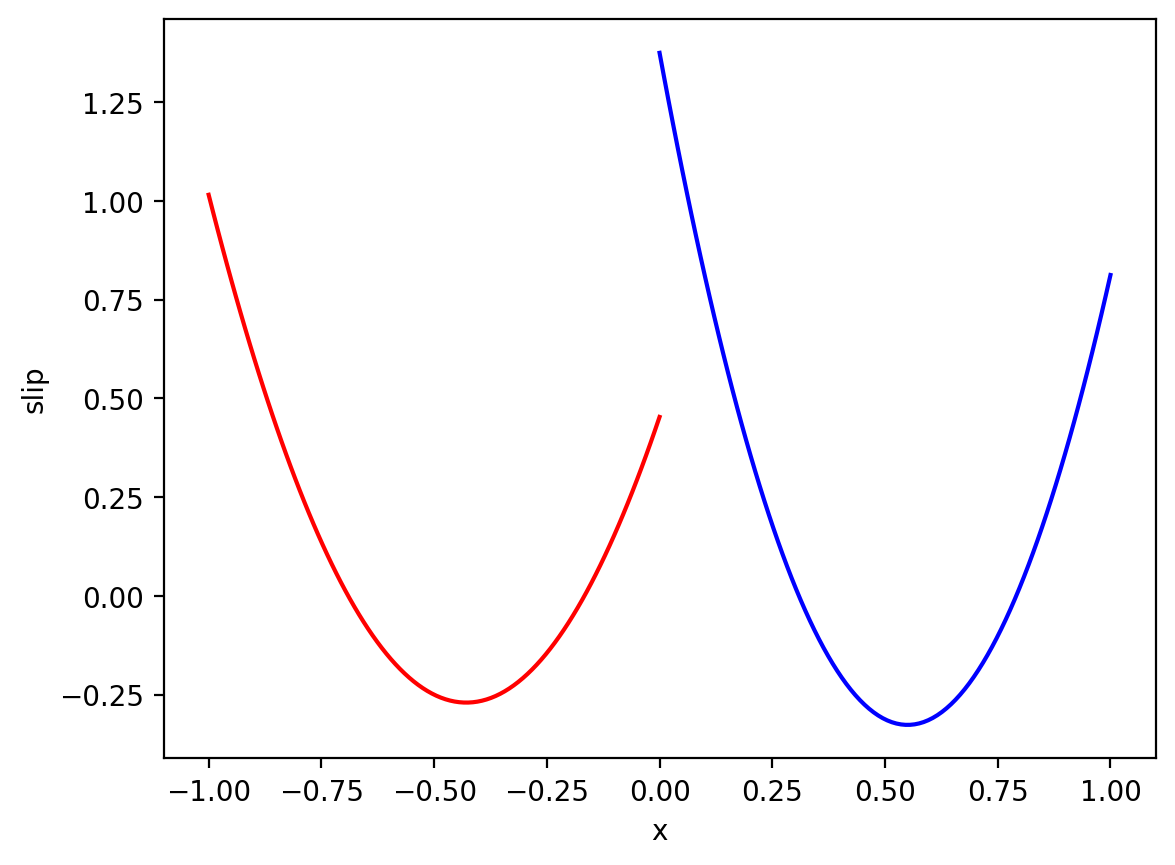

In [9]:
def get_ab_slip(x, a, phi_1, phi_2, phi_3):
    return phi_1 * f_ab_1(x, a) + phi_2 * f_ab_2(x, a) + phi_3 * f_ab_3(x, a)


def get_bc_slip(x, a, phi_1, phi_2, phi_3):
    return phi_1 * f_bc_1(x, a) + phi_2 * f_bc_2(x, a) + phi_3 * f_bc_3(x, a)


n_pts = 100
x_ab = np.linspace(x_a, x_b, n_pts)
x_bc = np.linspace(x_b, x_c, n_pts)

ab_slip = get_ab_slip(
    x_ab - x_ab_centroid,
    a,
    quadratic_weights[0],
    quadratic_weights[1],
    quadratic_weights[2],
)
bc_slip = get_bc_slip(
    x_bc - x_bc_centroid,
    a,
    quadratic_weights[3],
    quadratic_weights[4],
    quadratic_weights[5],
)

plt.figure()
plt.plot(x_ab, ab_slip, "-r", label="ab slip")
plt.plot(x_bc, bc_slip, "-b", label="bc slip")
plt.xlabel("x")
plt.ylabel("slip")
plt.show()
